In [83]:
import sweetviz as sv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Read data

In [84]:
A_est = pd.read_parquet('data/A/parquet/X_train_estimated.parquet', engine='pyarrow')
A_obs = pd.read_parquet('data/A/parquet/X_train_observed.parquet', engine='pyarrow')
A_test = pd.read_parquet('data/A/parquet/X_test_estimated.parquet', engine='pyarrow')
B_est = pd.read_parquet('data/B/parquet/X_train_estimated.parquet', engine='pyarrow')
B_obs = pd.read_parquet('data/B/parquet/X_train_observed.parquet', engine='pyarrow')
B_test = pd.read_parquet('data/B/parquet/X_test_estimated.parquet', engine='pyarrow')
C_est = pd.read_parquet('data/C/parquet/X_train_estimated.parquet', engine='pyarrow')
C_obs = pd.read_parquet('data/C/parquet/X_train_observed.parquet', engine='pyarrow')
C_test = pd.read_parquet('data/C/parquet/X_test_estimated.parquet', engine='pyarrow')

A_target = pd.read_parquet('data/A/parquet/train_targets.parquet', engine='pyarrow')
B_target = pd.read_parquet('data/B/parquet/train_targets.parquet', engine='pyarrow')
C_target = pd.read_parquet('data/C/parquet/train_targets.parquet', engine='pyarrow')

### Create test data

In [85]:
# merge X_train_observed and X_train_estimated (without its first column) into one dataframe
A_train = pd.concat([A_obs, A_est.iloc[:,1:]], axis=0)
B_train = pd.concat([B_obs, B_est.iloc[:,1:]], axis=0)
C_train = pd.concat([C_obs, C_est.iloc[:,1:]], axis=0)

# remove the first column of X_test_estimated
A_test = A_test.iloc[:,1:]
B_test = B_test.iloc[:,1:]
C_test = C_test.iloc[:,1:]

#### Convert index to datetime

In [86]:
def convert_timestamp_to_datetime(timestamp):
    try:
        # Convert Timestamp to Python datetime
        datetime_object = timestamp.to_pydatetime()
        return datetime_object
    except AttributeError as e:
        print(f"Error: {e}")
        return None

In [87]:
A_train['date_forecast'] = A_train['date_forecast'].apply(convert_timestamp_to_datetime)
A_train.set_index('date_forecast', inplace=True)
B_train['date_forecast'] = B_train['date_forecast'].apply(convert_timestamp_to_datetime)
B_train.set_index('date_forecast', inplace=True)
C_train['date_forecast'] = C_train['date_forecast'].apply(convert_timestamp_to_datetime)
C_train.set_index('date_forecast', inplace=True)

In [88]:
A_target['time'] = A_target['time'].apply(convert_timestamp_to_datetime)
A_target.set_index('time', inplace=True)
B_target['time'] = B_target['time'].apply(convert_timestamp_to_datetime)
B_target.set_index('time', inplace=True)
C_target['time'] = C_target['time'].apply(convert_timestamp_to_datetime)
C_target.set_index('time', inplace=True)

In [89]:
A_test['date_forecast'] = A_test['date_forecast'].apply(convert_timestamp_to_datetime)
A_test.set_index('date_forecast', inplace=True)
B_test['date_forecast'] = B_test['date_forecast'].apply(convert_timestamp_to_datetime)
B_test.set_index('date_forecast', inplace=True)
C_test['date_forecast'] = C_test['date_forecast'].apply(convert_timestamp_to_datetime)
C_test.set_index('date_forecast', inplace=True)

In [90]:
# add the target column to the training data
A_train['pv_measurement'] = A_target['pv_measurement']

A_train.to_csv('data/A/parquet/A_train.csv', index=False)

A_train.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,pv_measurement
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-06-02 22:00:00,7.7,1.230,1744.900024,0.0,0.0,1744.900024,0.0,280.299988,0.0,0.0,...,-3.202,0.0,285.899994,100.0,39640.101562,3.7,-3.6,-0.8,-0.0,0.0
2019-06-02 22:15:00,7.7,1.229,1734.000000,0.0,0.0,1734.000000,0.0,280.299988,0.0,0.0,...,-3.650,0.0,286.100006,100.0,40123.898438,3.6,-3.6,-0.6,-0.0,NaN
2019-06-02 22:30:00,7.7,1.228,1723.500000,0.0,0.0,1723.500000,0.0,280.299988,0.0,0.0,...,-3.998,0.0,286.299988,100.0,40628.300781,3.6,-3.6,-0.4,-0.0,NaN
2019-06-02 22:45:00,7.7,1.226,1713.400024,0.0,0.0,1713.400024,0.0,280.299988,0.0,0.0,...,-4.247,0.0,286.600006,100.0,41153.601562,3.5,-3.5,-0.2,-0.0,NaN
2019-06-02 23:00:00,7.7,1.225,1703.599976,0.0,0.0,1703.599976,0.0,280.299988,0.0,0.0,...,-4.393,0.0,286.799988,100.0,41699.898438,3.5,-3.5,0.0,-0.0,0.0


## Feature creation

In [100]:
A_target['hour'] = A_target.index.hour
A_target['day_of_week'] = A_target.index.day_of_week
A_target['quarter'] = A_target.index.quarter
A_target['month'] = A_target.index.month
A_target['year'] = A_target.index.year
A_target['day_of_year'] = A_target.index.dayofyear
A_target['day_of_month'] = A_target.index.day
A_target['week_of_year'] = A_target.index.weekofyear

A_test['hour'] = A_test.index.hour
A_test['day_of_week'] = A_test.index.day_of_week
A_test['quarter'] = A_test.index.quarter
A_test['month'] = A_test.index.month
A_test['year'] = A_test.index.year
A_test['day_of_year'] = A_test.index.dayofyear
A_test['day_of_month'] = A_test.index.day
A_test['week_of_year'] = A_test.index.weekofyear

A_train['hour'] = A_train.index.hour
A_train['day_of_week'] = A_train.index.day_of_week
A_train['quarter'] = A_train.index.quarter
A_train['month'] = A_train.index.month
A_train['year'] = A_train.index.year
A_train['day_of_year'] = A_train.index.dayofyear
A_train['day_of_month'] = A_train.index.day
A_train['week_of_year'] = A_train.index.weekofyear

/var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/ipykernel_25040/829798513.py:8: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  A_target['week_of_year'] = A_target.index.weekofyear
/var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/ipykernel_25040/829798513.py:17: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns a Series. To exactly reproduce the behavior of week and weekofyear and return an Index, you may call pd.Int64Index(idx.isocalendar().week)
  A_test['week_of_year'] = A_test.index.weekofyear
/var/folders/1d/b_59w_9j0kx4nzfn4hkp84lc0000gn/T/ipykernel_25040/829798513.py:26: FutureWarning: weekofyear and week have been deprecated, please use DatetimeIndex.isocalendar().week instead, which returns

Text(0.5, 1.0, 'Boxplot of pv_measurement by hour')

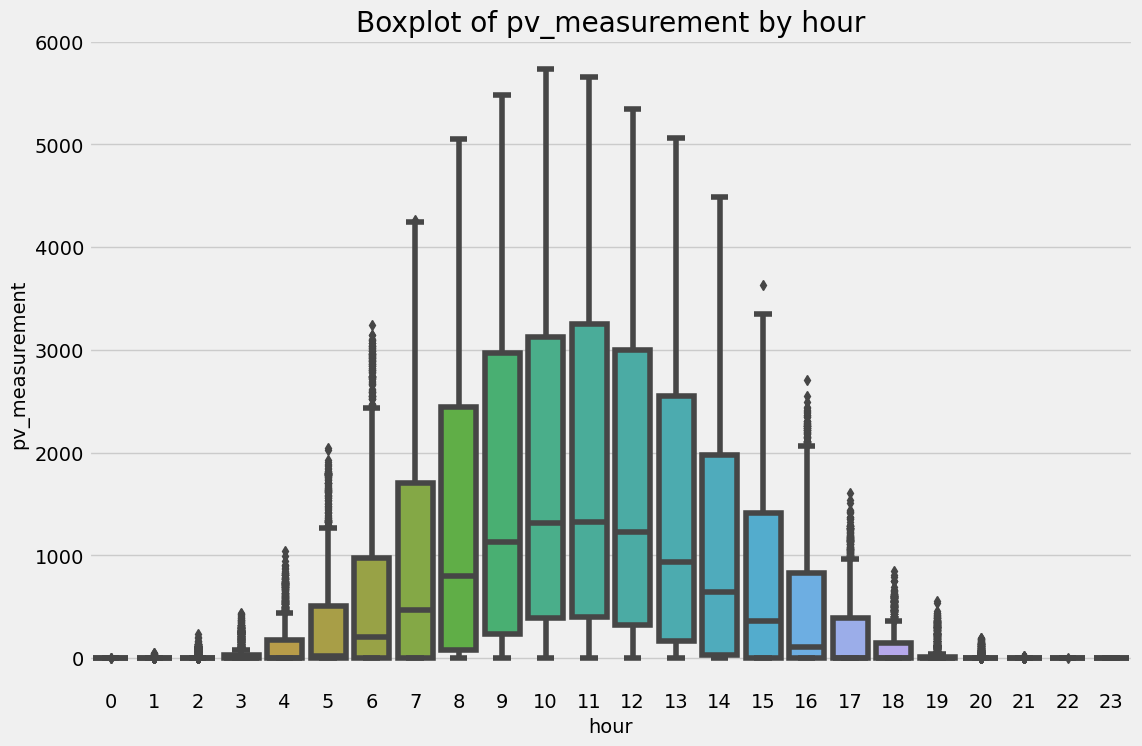

In [92]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=A_target, x='hour', y='pv_measurement')
ax.set_title('Boxplot of pv_measurement by hour')

Text(0.5, 1.0, 'Boxplot of pv_measurement by month')

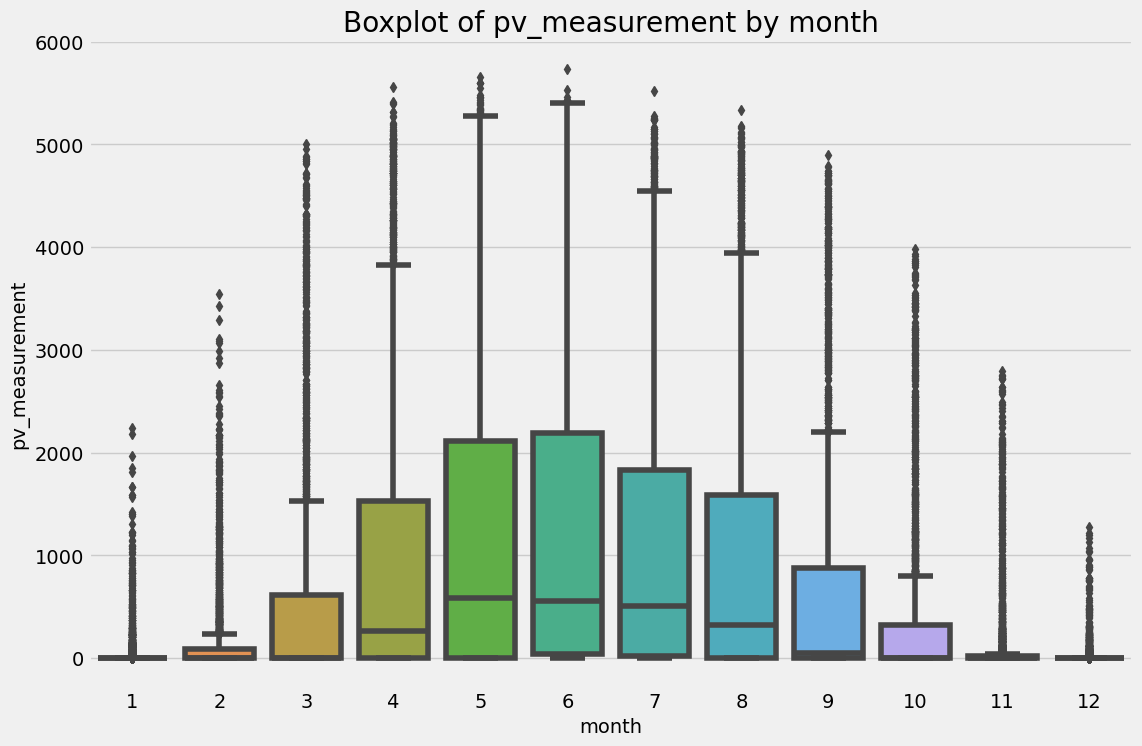

In [93]:
fig, ax = plt.subplots(figsize=(12,8))
sns.boxplot(data=A_target, x='month', y='pv_measurement')
ax.set_title('Boxplot of pv_measurement by month')

In [120]:
A_train.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,wind_speed_w_1000hPa:ms,pv_measurement,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-06-02 22:00:00,7.7,1.230,1744.900024,0.0,0.0,1744.900024,0.0,280.299988,0.0,0.0,...,-0.0,0.0,22,6,2,6,2019,153,2,22
2019-06-02 22:15:00,7.7,1.229,1734.000000,0.0,0.0,1734.000000,0.0,280.299988,0.0,0.0,...,-0.0,NaN,22,6,2,6,2019,153,2,22
2019-06-02 22:30:00,7.7,1.228,1723.500000,0.0,0.0,1723.500000,0.0,280.299988,0.0,0.0,...,-0.0,NaN,22,6,2,6,2019,153,2,22
2019-06-02 22:45:00,7.7,1.226,1713.400024,0.0,0.0,1713.400024,0.0,280.299988,0.0,0.0,...,-0.0,NaN,22,6,2,6,2019,153,2,22
2019-06-02 23:00:00,7.7,1.225,1703.599976,0.0,0.0,1703.599976,0.0,280.299988,0.0,0.0,...,-0.0,0.0,23,6,2,6,2019,153,2,22


In [133]:
# create a features list containing all the features in the top row of A_train
FEATURES = list(A_train.columns)
FEATURES.remove('pv_measurement')
# FEATURES = ['hour', 'day_of_week', 'quarter', 'month', 'year', 'cloud_base_agl:m']
TARGET = 'pv_measurement'

X_train = A_train[FEATURES]
y_train = A_train[TARGET]

# In both X_train and y_train, we have to remove the rows where the target is NaN
X_train = X_train[~y_train.isna()]
y_train = y_train[~y_train.isna()]



In [128]:
X_train.head()

,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,...,wind_speed_w_1000hPa:ms,pv_measurement,hour,day_of_week,quarter,month,year,day_of_year,day_of_month,week_of_year
date_forecast,,,,,,,,,,,,,,,,,,,,,
2019-06-02 22:00:00,7.7,1.230,1744.900024,0.000000,0.0,1744.900024,0.0,280.299988,0.0,0.000000,...,-0.0,0.00,22,6,2,6,2019,153,2,22
2019-06-02 23:00:00,7.7,1.225,1703.599976,0.000000,0.0,1703.599976,0.0,280.299988,0.0,0.000000,...,-0.0,0.00,23,6,2,6,2019,153,2,22
2019-06-03 00:00:00,7.7,1.221,1668.099976,0.000000,0.0,1668.099976,0.0,280.200012,0.0,0.000000,...,-0.0,0.00,0,0,2,6,2019,154,3,23
2019-06-03 01:00:00,8.2,1.218,1388.400024,0.000000,0.0,1388.400024,0.0,281.299988,0.0,0.000000,...,-0.0,0.00,1,0,2,6,2019,154,3,23
2019-06-03 02:00:00,8.8,1.219,1108.500000,6546.899902,9.8,1108.500000,0.0,282.299988,4.3,7743.299805,...,-0.0,19.36,2,0,2,6,2019,154,3,23


In [122]:
y_train.head()

date_forecast
2019-06-02 22:00:00     0.00
2019-06-02 23:00:00     0.00
2019-06-03 00:00:00     0.00
2019-06-03 01:00:00     0.00
2019-06-03 02:00:00    19.36
Name: pv_measurement, dtype: float64

# Create a model

In [134]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       learning_rate=0.01)

reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [135]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])


<Axes: >

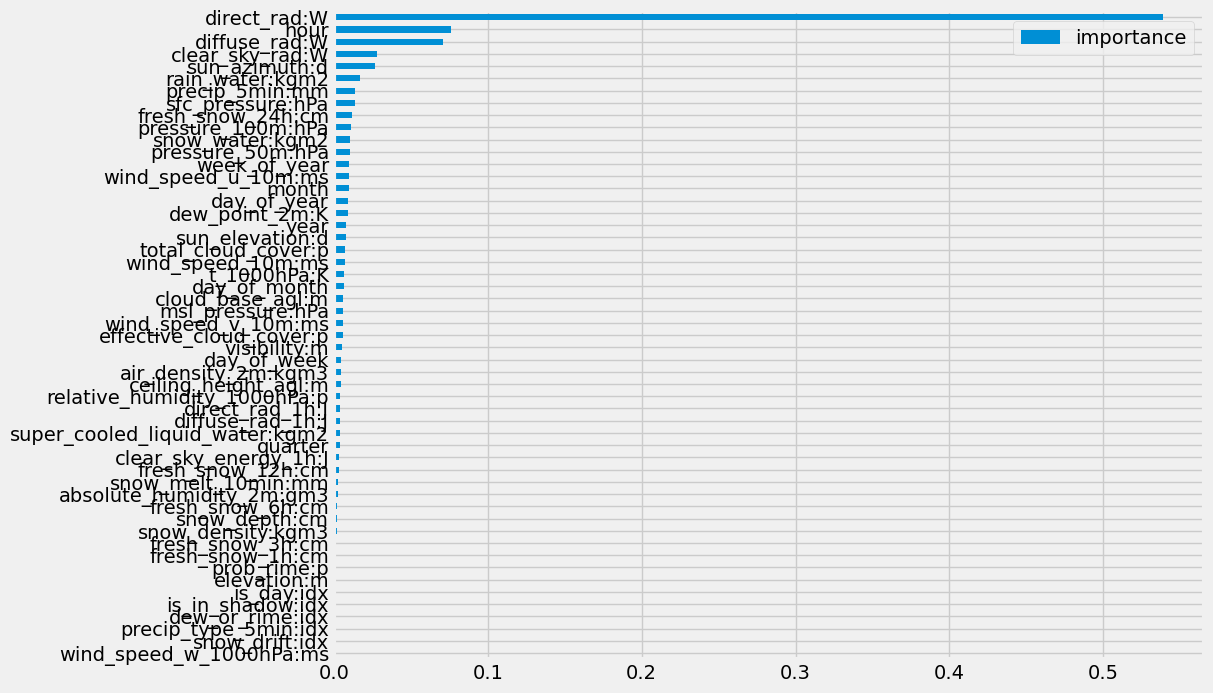

In [136]:
fi.sort_values(by='importance').plot(kind='barh', figsize=(10,8))

<Axes: xlabel='hour', ylabel='pv_prediction'>

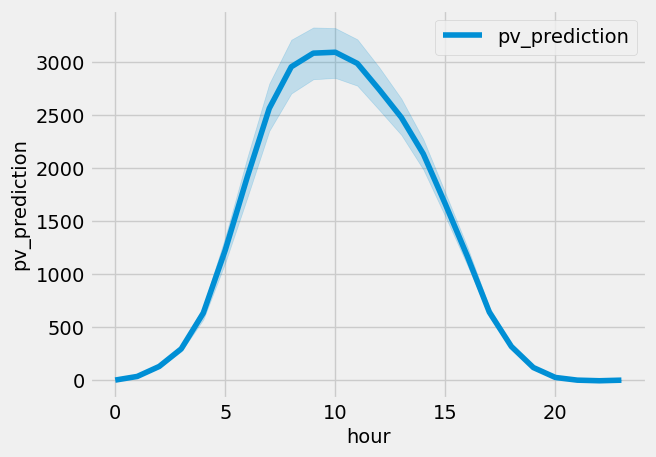

In [153]:
A_results = A_test.copy()

# remov all columns in A_results except the index, and time related features
A_results = A_results[['hour', 'day_of_week', 'quarter', 'month', 'year', 'day_of_year', 'day_of_month', 'week_of_year']]
res = reg.predict(A_test[FEATURES])
res = pd.DataFrame(data=res, index=A_test.index, columns=['pv_prediction'])
A_results["pv_prediction"] = pd.DataFrame(data=res)

sns.lineplot(data=A_results, x='hour', y='pv_prediction', label='pv_prediction')


<Axes: xlabel='hour', ylabel='pv_measurement'>

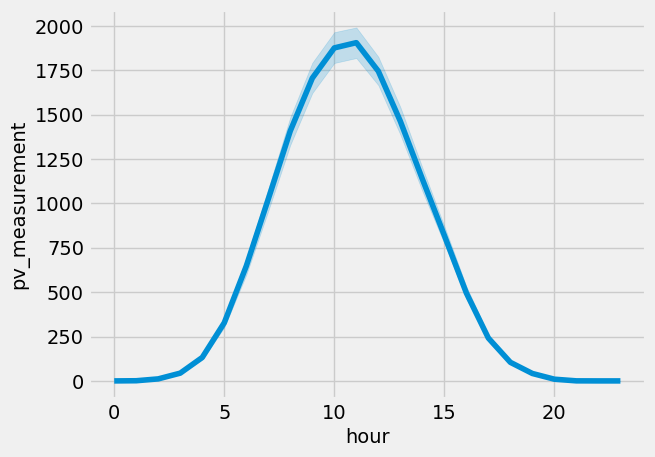

In [154]:
sns.lineplot(data=A_target, x='hour', y='pv_measurement')